# Tècniques d'intel·ligència artificial aplicades a la selecció d'actius de renda variable

## Definició del problema

L'objectiu principal d'aquest estudi és crear un model d'aprenentatge automàtic usant *Python* i les seves llibreries que faci prediccions el més eficients possibles de dades reals del mercat financer.

Més concretament, es desenvoluparà una xarxa neuronal artificial *LSTM* per a predir valors futurs del rendiment setmanal logarítmic de l'índex borsari Standard & Poor's 500 (S&P500) utilitzant diferents dades fonamentals històriques del mercat borsari i altres dades macroeconòmiques. Per a facilitar el procés i intentar millorar el rendiment final, s'utilitzarà l'*optuna* com a recurs per a l'optimització d'hiper-paràmetres.

### Selecció de dades econòmiques

Abans de començar a desenvolupar el programa de l'estudi, és necessari fer una exploració de les dades de mercat disponibles i fer-ne una selecció de les que es consideri que poden tenir influència en el valor objectiu a predir: el rendiment setmanal logarítmic de l'índex S&P500.

La selecció final es presenta desglossada en dues categories, segons si es tracta d'una dada fonamental del mercat borsari o d'una dada macroeconòmica. A més, es consideraran dades únicament corresponents a l'interval temporal de l'1 de gener de 2004 fins al 31 de desembre de 2022.

In [27]:
import datetime
inici = datetime.datetime(2004, 1, 1)
fi = datetime.datetime(2022, 12, 31)

#### Dades fonamentals

Totes les dades fonamentals s'han extret de `https://finance.yahoo.com/`: s'han buscat mitjançant el seu símbol corresponent i s'ha descarregat la taula amb totes les dades històriques diàries disponibles dins el rang temporal d'estudi en format `.csv`. Tots els valors obtinguts venen en unitats USD (dòlar estatunidenc). A continuació, es detalla la llista amb l'abreviació que se'ls ha assignat per l'estudi i una breu explicació del que representen:

- Índex Standard & Poor's 500 (S&P500): índex borsari que inclou les 500 empreses més importants dels Estats Units.
- Accions d'Apple, Microsoft i Amazon (AAPL, MSFT i AMZN, respectivament): són les 3 empreses amb més pes dins l'índex S&P500.
- Mitjana Industrial Dow Jones (DJIA): índex que mesura el comportament de les 30 companyies més grans dels Estats Units.
- Índex de volatilitat CBOE (VIX): indica la volatilitat esperada en la borsa dels Estats Units segons el comportament del S&P500.
- Índex del dòlar estatunidenc (USD): mesura el valor del dòlar estatunidenc relatiu a un conjunt de divises.
- Accions de l'or i el petroli (GOLD i OIL, respectivament).
- Canvi de les divises GBP, EUR i JPY respecte de USD (GBP-USD, EUR-USD i JPY-USD, respectivament): tipus de canvi de la lliura anglesa, l'euro i el ien japonès amb el dòlar estatunidenc.
- Rendiment d'Hisenda a 5 i 10 anys (FVX i TNX, respectivament): taxa d'interès anual efectiva que el govern dels Estats Units paga pels diners que pren en préstec durant 5 o 10 anys (respectivament) per recaptar capital mitjançant la venta de bonus d'Hisenda.

#### Dades macroeconòmiques

Per a les dades macroeconòmiques s'ha consultat el banc de dades `https://fred.stlouisfed.org/`. La majoria d'elles estan disponibles únicament en freqüència mensual i les unitats en què estan disposades varien d'unes a les altres. Vegem-ne un llistat amb els detalls:

- Taxa d'interès de fons federals (EFFR).
- Sol·licituds d'assegurança d'atur (IJC): nombre de so"licituds de l'assegurança per atur als Estats Units.
- Percentatge d'atur (UNRATE): percentatge de persones amb edat legal de treballar que es troben a l'atur als Estats Units.
- Sentiment dels clients (UMCSENT): índex que mesura una estimació de futures compres i estalvis mitjançant enquestes de la Universitat de Michigan als clients. Com a unitat de mesura, s'ha assignat un valor de 100 als resultat obtinguts a l'inici de l'any 1966 i la resta de valors s'han ponderat en comparació a aquest.
- Nòmines no agrícoles (NFP): indicador econòmic que mostra el canvi de treballadors dels Estats Units, excloent les relatives al sector agrícola.
- Despeses de consum personal (PCE): mesura de dòlars que els residents dels Estats Units es gasten per a béns i serveis personals.
- Índex de producció industrial (IPI): mesura els nivells de producció i capacitat als Estats Units de les indústries manufactureres, elèctriques, de mineria i de gas, relatives a un any. Com a unitat de mesura, s'ha assignat un valor de 100 als resultat obtinguts a l'inici de l'any 2017 i la resta de valors s'han ponderat en comparació a aquest.
- Percentatge d'estalvis personals (PSAVERT): taxa d'ingressos considerats estalvis personals dels residents d'Estats Units.

In [28]:
etiqueta = 'SP500'
fonamentals = ['SP500', 'AAPL', 'MSFT', 'AMZN', 'DJIA', 'VIX', 'USD', 'GOLD', 'OIL',
               'GBP-USD', 'EUR-USD', 'JPY-USD', 'FVX', 'TNX']

macro_diaria = ['EFFR']
macro_setmanal = ['IJC']
macro_mensual = ['UNRATE', 'UMCSENT', 'NONFRM', 'PCE', 'IPI', 'PSAVERT']
macro = macro_diaria + macro_setmanal + macro_mensual

## Preparació de les dades

### Importació de les llibreries

In [29]:
import pandas as pd
import numpy as np

from utils import transformacio_dades as td
from utils import utilitats_dates as ud
from utils import visualitzacio_dades as vd
from utils import personalitzacio_model as pm

import warnings
warnings.filterwarnings('ignore')

### Càrrega de les dades

El primer pas un cop ja s'han descarregat les taules de dades reals del mercat, és guardar-les en el mateix directori del projecte. D'aquesta manera, es pot fer ús de la llibreria *pandas* per a carregar-les i emmagatzemar-les en format `DataFrame` dins del programa, ja que aquesta estructura de dades permet assignar el tic temporal associat a cada dada econòmica com a índex per a identificar les files de la taula de dades, i usar els noms de les columnes per a saber què emmagatzema cada una.

In [30]:
dada = pd.read_csv('data/' + etiqueta + '.csv', index_col=0)
dada.index = pd.to_datetime(dada.index)
dada.head(7)

Open         High          Low        Close    Adj Close  \
Date                                                                          
2004-01-02  1111.920044  1118.849976  1105.079956  1108.479980  1108.479980   
2004-01-05  1108.479980  1122.219971  1108.479980  1122.219971  1122.219971   
2004-01-06  1122.219971  1124.459961  1118.439941  1123.670044  1123.670044   
2004-01-07  1123.670044  1126.329956  1116.449951  1126.329956  1126.329956   
2004-01-08  1126.329956  1131.920044  1124.910034  1131.920044  1131.920044   
2004-01-09  1131.920044  1131.920044  1120.900024  1121.859985  1121.859985   
2004-01-12  1121.859985  1127.849976  1120.900024  1127.229980  1127.229980   

                Volume  
Date                    
2004-01-02  1153200000  
2004-01-05  1578200000  
2004-01-06  1494500000  
2004-01-07  1704900000  
2004-01-08  1868400000  
2004-01-09  1720700000  
2004-01-12  1510200000

Notem la presència de 6 columnes de dades a part de la indexada pel tic temporal corresponent: `Open`, `High`, `Low`, `Close`, `Adj Close` i `Volume`. Les 4 primeres fan referència al primer, màxim, menor i últim preu (en USD) de l'índex negociats d'aquell dia. `Adj Close` indica el preu final després d'ajustar els dividends i les particions i `Volume` mesura la quantitat total d'accions negociades al llarg d'aquell dia.

La que resulta d'interès per l'estudi és `Adj Close`, ja que és mitjançant la qual es calcula el rendiment logarítmic de l'índex. Així doncs, vegem-ne una representació per a fer-nos una primera idea del comportament que segueixen les dades amb les què s'està treballant.

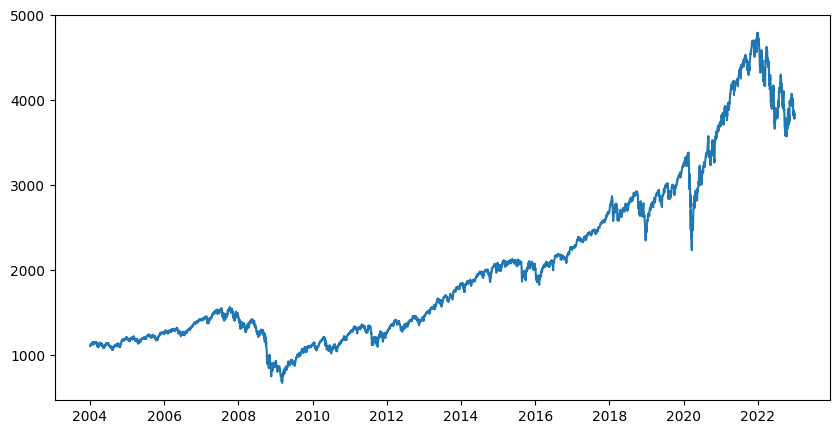

In [31]:
vd.grafic_dades([dada['Adj Close']], guardar='assets/SP500_stock.png')

La càrrega i exploració anterior es repeteix per a totes les variables considerades per a l'estudi i s'emmagatzemen de manera interna mitjançant un diccionari, que té com a *claus* les abreviacions de cada variable i com a *valors* les dades indexades corresponents. Per a les dades fonamentals, es guarda únicament la columna amb el preu de tancament ajustat, ja que les altres no són utilitzades per la simulació. Les variables macroeconòmiques consten d'una única columna amb dades, així que no cal fer cap pre-selecció.

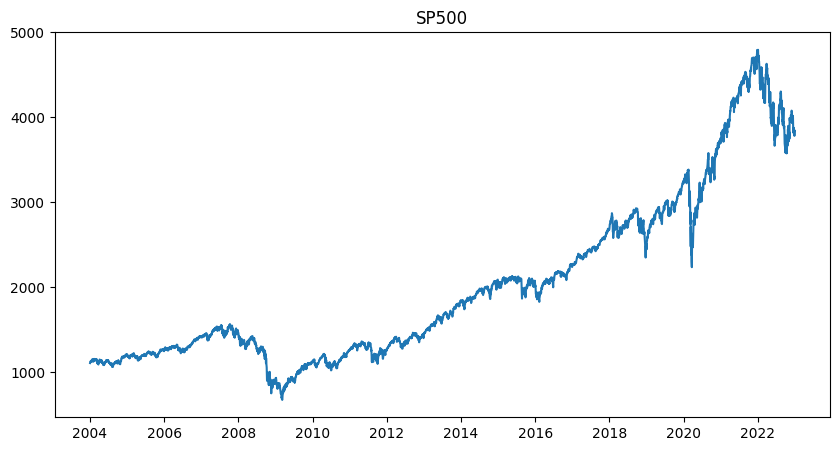

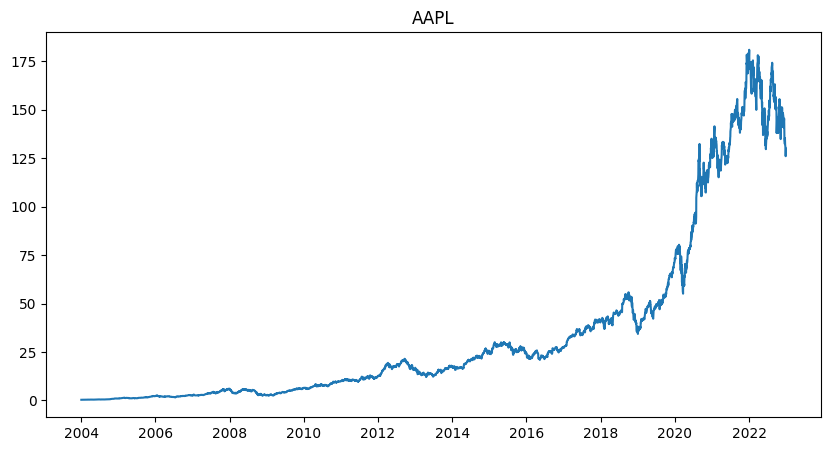

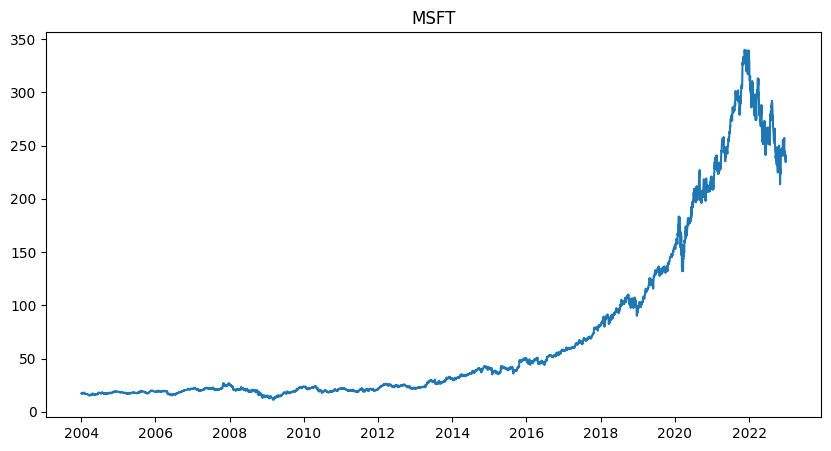

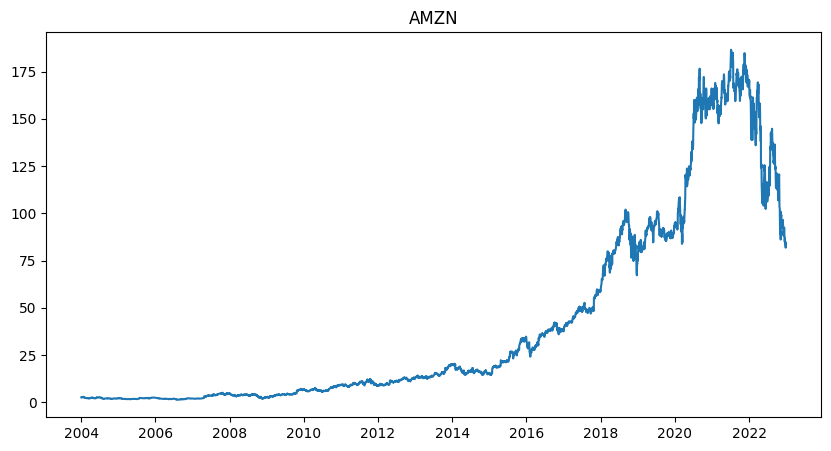

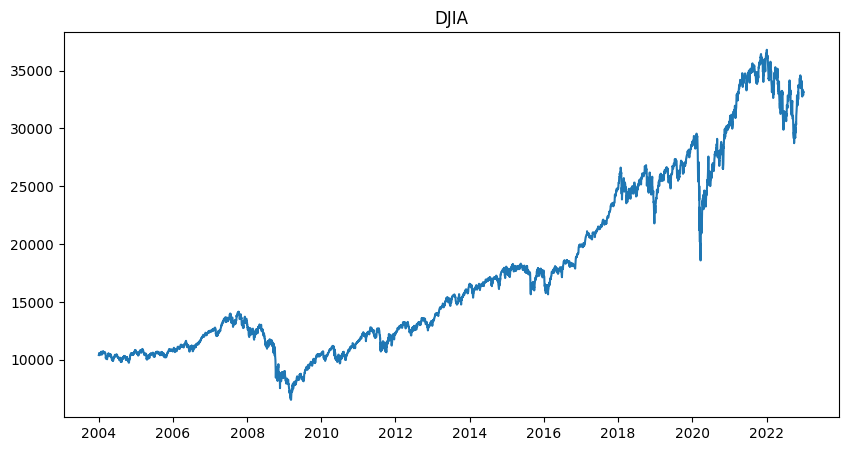

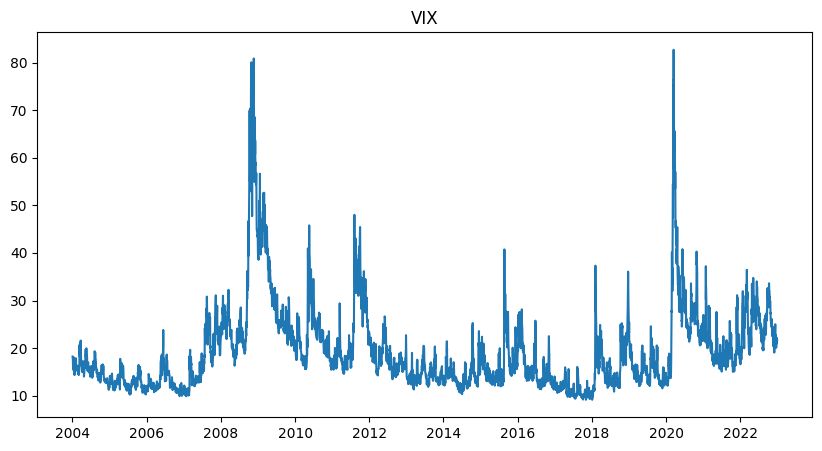

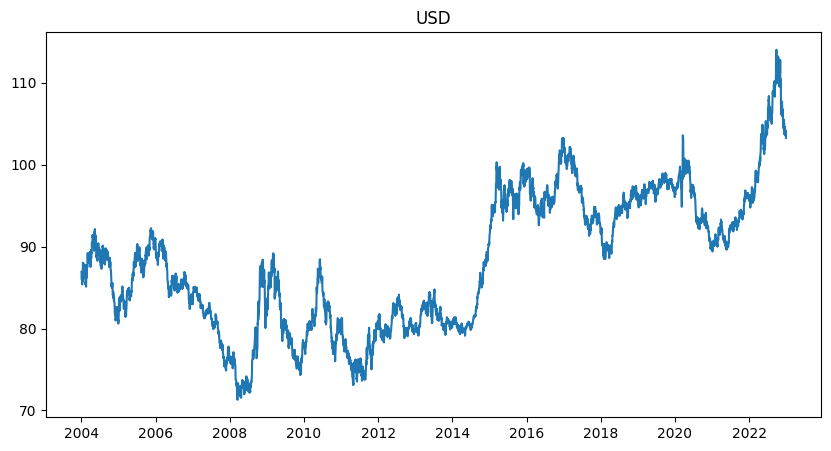

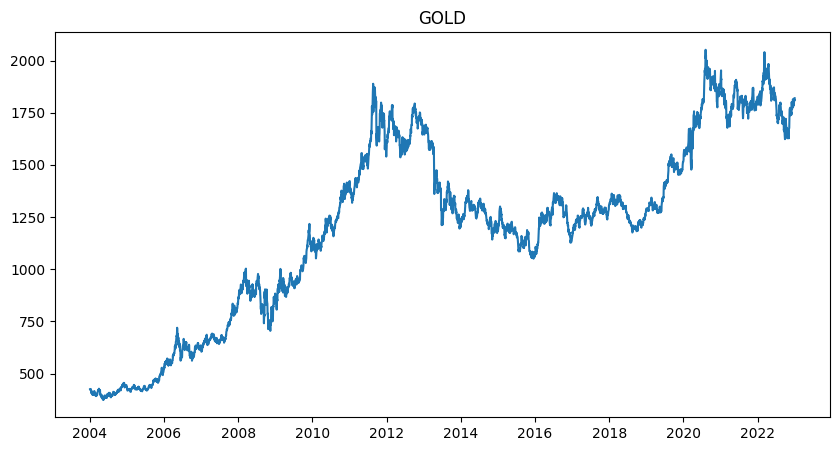

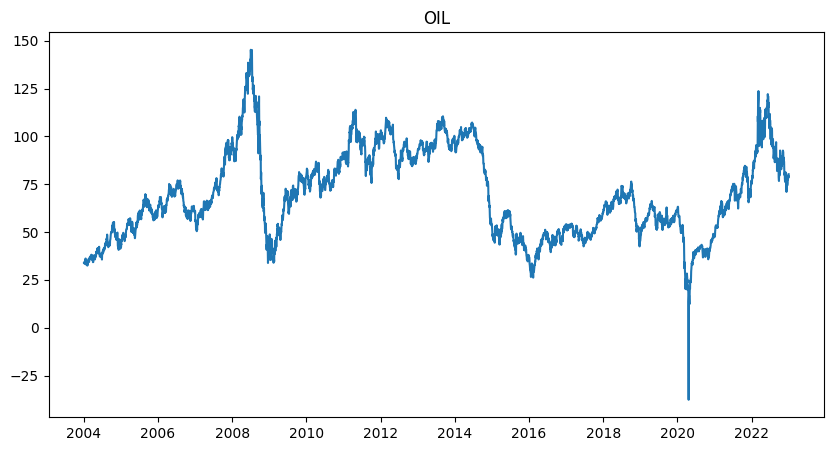

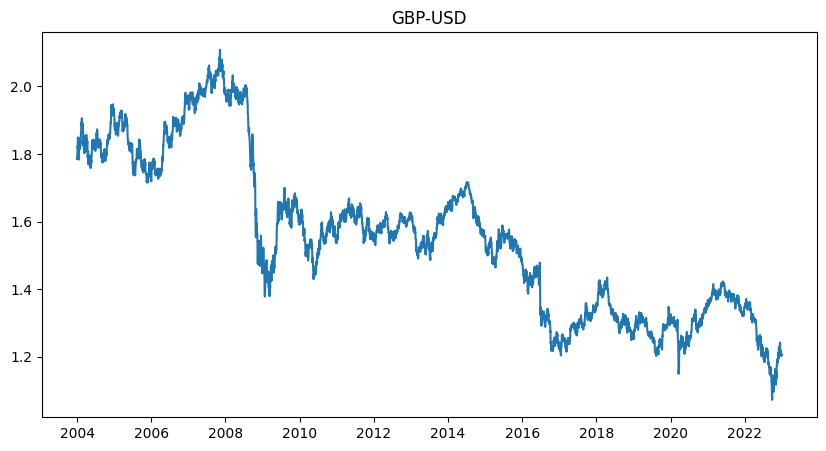

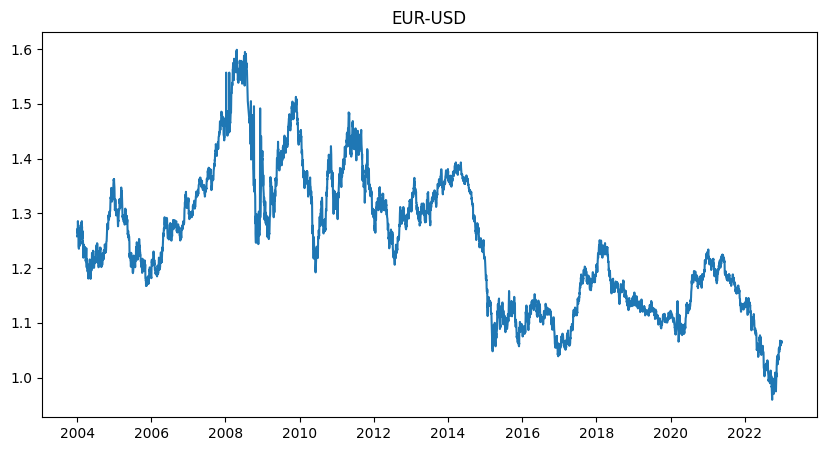

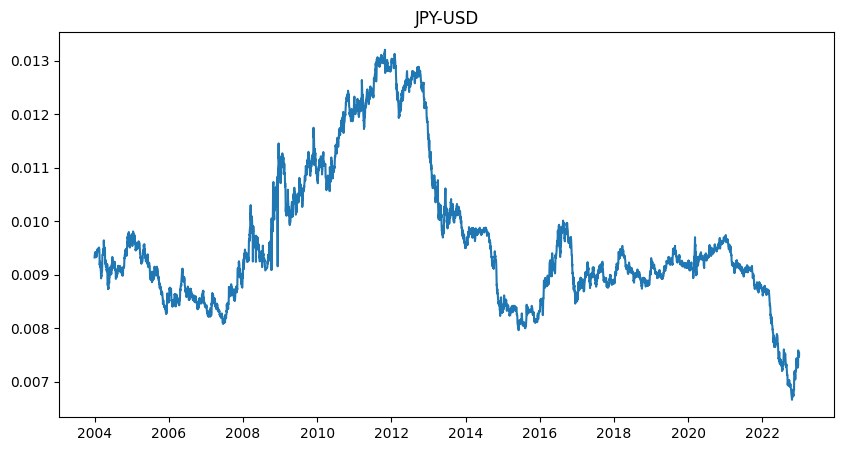

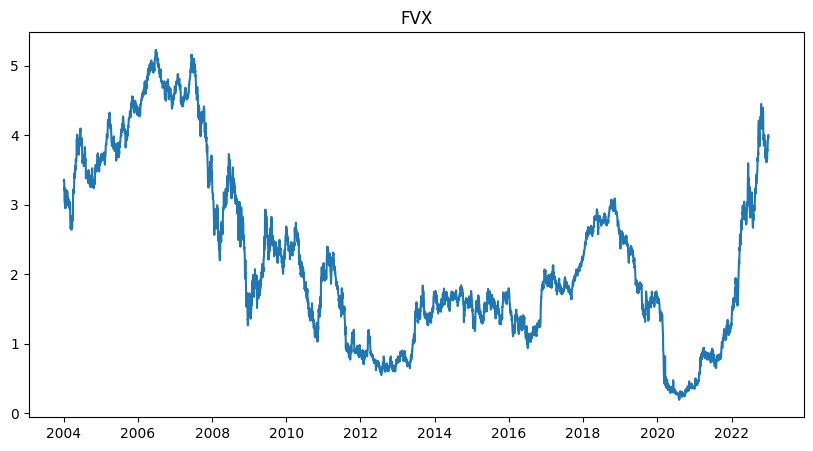

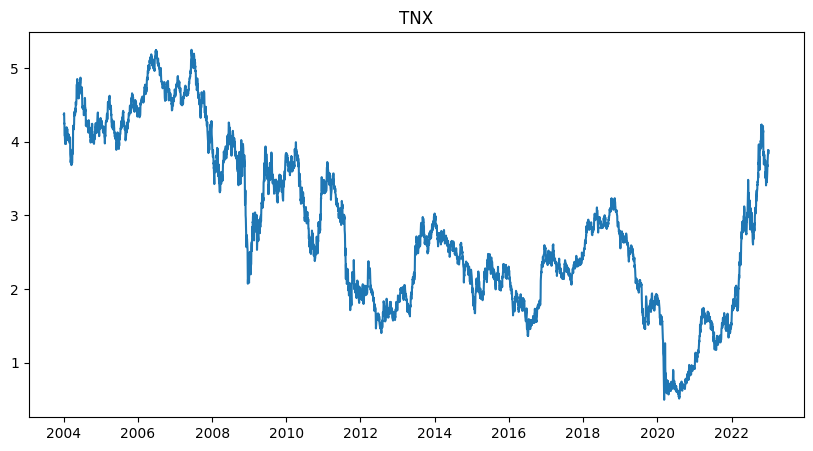

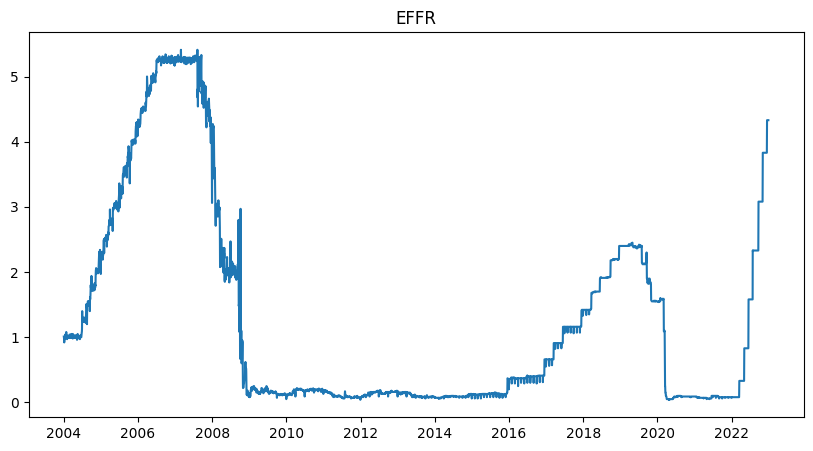

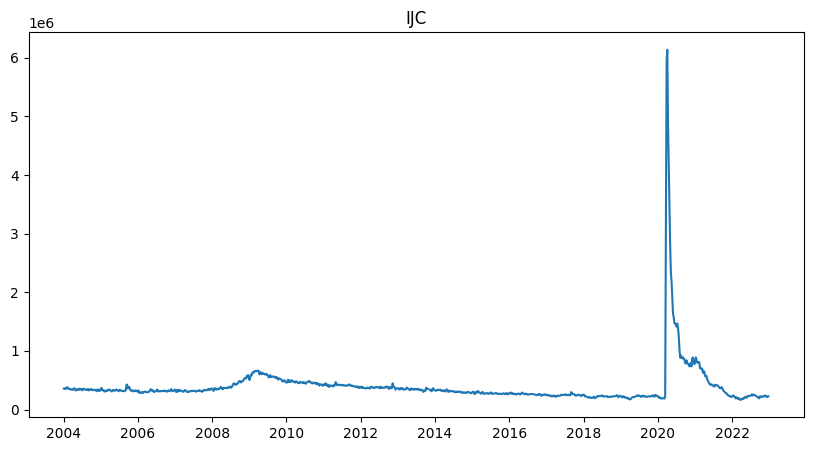

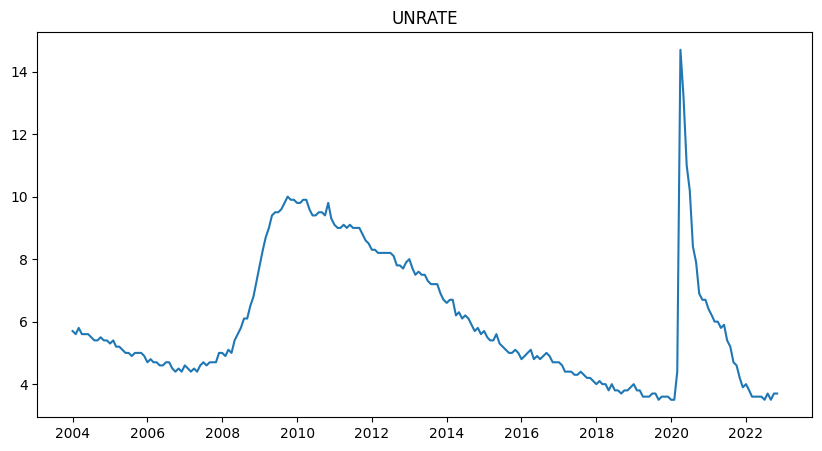

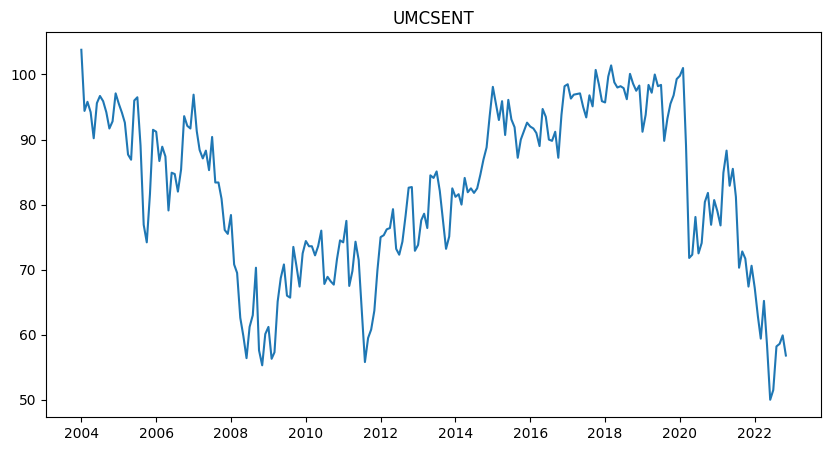

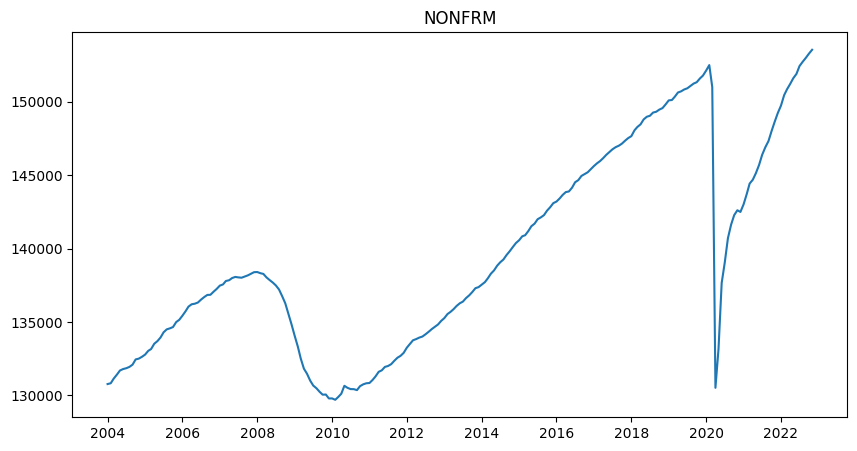

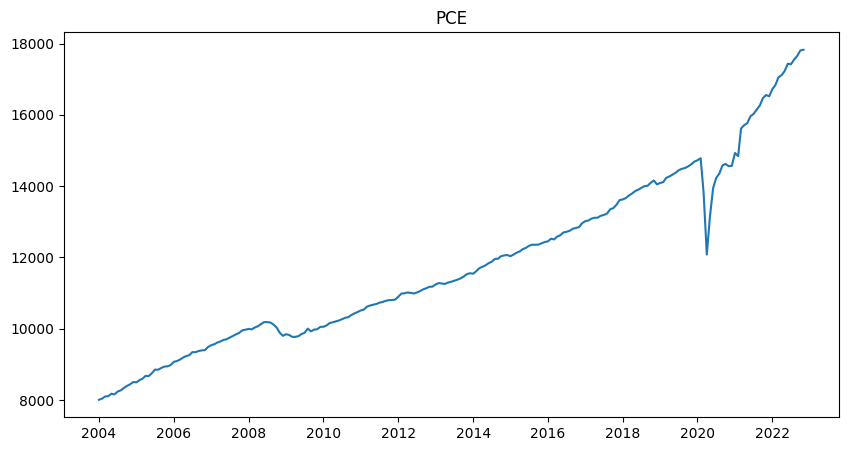

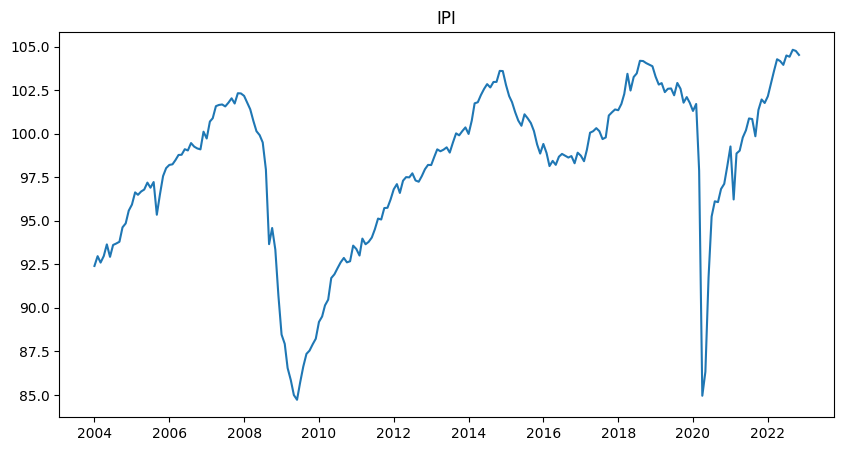

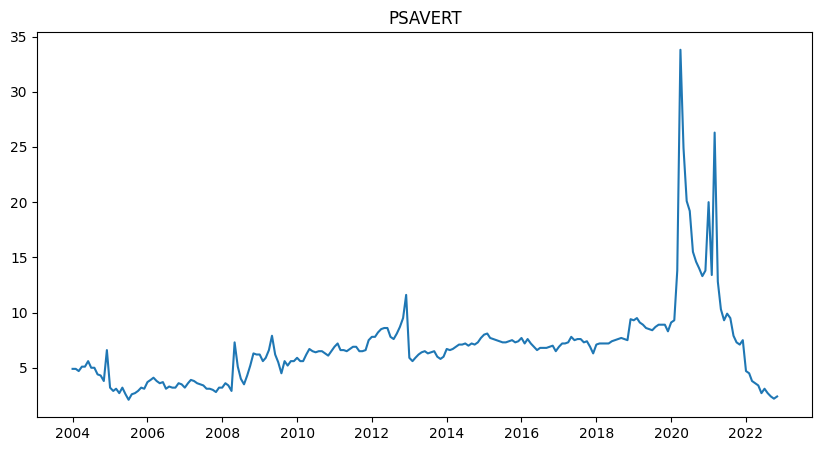

In [32]:
dic_dades_crues = {}
for simbol in fonamentals:
    dada = pd.read_csv('data/' + simbol + '.csv', index_col=0)
    dada.index = pd.to_datetime(dada.index)
    dic_dades_crues[simbol] = pd.DataFrame(dada['Adj Close'])
    vd.grafic_dades([dic_dades_crues[simbol]], titol=simbol)
for simbol in macro:
    dada = pd.read_csv('data/' + simbol + '.csv', index_col=0)
    dada.index = pd.to_datetime(dada.index)
    dic_dades_crues[simbol] = pd.DataFrame(dada[dada.columns[0]])
    vd.grafic_dades([dic_dades_crues[simbol]], titol=simbol)

### Pre-processament

Les dades de les què es disposa són crues i requereixen d'un tractament i transformació abans de poder ser usades com a característiques pel model. Els passos concrets d'aquestes transformacions varien segons els detalls tècnics de cada problema. Per aquest estudi concret, s'han fet els que es detallen a continuació.

#### Gestió de dades que falten

Primerament, cal entendre la freqüència en la què venen i unificar-les per a què coincideixin els seus índexs temporals. Totes les dades fonamentals estan en format diari i, en general, tenen un valor assignat per a cada dia laborable (de dilluns a divendres) de l'any, ja que són els dies en què el mercat borsari està obert. Per a les dades macroeconòmiques la situació és diferent: la primera d'elles (EFFR) també és diària, però la segona (IJC) és setmanal amb un valor associat a cada dissabte de l'any, i la resta són mensuals amb el valor assignat al dia 1 de cada mes.

L'objectiu del problema és fer un estudi del comportament setmanal de les dades; en particular, es fixa com a inici de setmana els dilluns per a totes les dades i els càlculs pertinents es faran de dilluns a dilluns. Així doncs, per a les dades diàries no cal fer cap ajustament temporal i per la variable setmanal és suficient traslladar la dada del dissabte al dilluns d'aquella mateixa setmana. Per a fer la unificació dels tics temporals amb les dades mensuals, però, cal un ajustament una mica més elaborat. Una primera opció consisteix en assignar a cada dilluns del mes el mateix valor però, però s'ha optat per fer una interpolació lineal entre els valors de mesos consecutius per a què en cada setmana es vegin reflectits en certa mesura els canvis que pateix la variable amb l'avanç del temps.

Per altra banda, en ocasions també poden faltar dades corresponents a dies laborables de les variables diàries. Mitjançant la funció `percentatge_dades_faltants` es pot fer un recompte de quin percentatge de dades falten per a cadascuna d'aquestes variables.

In [33]:
for dada_diaria in fonamentals + macro_diaria:
    faltants = ud.percentatge_dades_faltants(dic_dades_crues[dada_diaria])
    print('- Percentatge de dades faltants de la variable ' + dada_diaria + ' = ' + str(faltants) + ' %')

- Percentatge de dades faltants de la variable SP500 = 0.034907183212267934 %
- Percentatge de dades faltants de la variable AAPL = 0.034907183212267934 %
- Percentatge de dades faltants de la variable MSFT = 0.034907183212267934 %
- Percentatge de dades faltants de la variable AMZN = 0.034907183212267934 %
- Percentatge de dades faltants de la variable DJIA = 0.034907183212267934 %
- Percentatge de dades faltants de la variable VIX = 0.034907183212267934 %
- Percentatge de dades faltants de la variable USD = 0.032687651331719136 %
- Percentatge de dades faltants de la variable GOLD = 0.03652875882946516 %
- Percentatge de dades faltants de la variable OIL = 0.035519677093844626 %
- Percentatge de dades faltants de la variable GBP-USD = 0.003429493645350057 %
- Percentatge de dades faltants de la variable EUR-USD = 0.005850312689126502 %
- Percentatge de dades faltants de la variable JPY-USD = 0.005850312689126502 %
- Percentatge de dades faltants de la variable FVX = 0.036117836965294

Cridant aquesta funció per a totes les dades amb freqüència diària s'ha observat que en cap cas les dades que falten suposen més d'un 0.05 % del total. Per tant, s'ha usat de nou el recurs d'interpolació lineal per a omplir aquests valors i així disposar d'un conjunt de dades més complet sense que el rendiment del model es vegi afectat negativament per haver usat una distribució d'interpolació diferent a la distribució real que segueixen les dades.

Així doncs, arribat a aquest punt es poden unificar totes les dades crues en una única taula de dades indexada per tots els dies laborables dins l'interval de temps fixats per l'estudi. A continuació, es poden excloure totes les files que no corresponguin a un dilluns i emmagatzemar el conjunt resultant en una variable `dades_crues` indexada amb una freqüència temporal setmanal.

In [34]:
dades_crues = pd.DataFrame(None, index=ud.dies_entre_setmana(inici=inici, fi=fi))

# diaries
for dada_diaria in fonamentals + macro_diaria:
    dades_crues[dada_diaria] = td.interpolacio_lineal(dic_dades_crues[dada_diaria])

# setmanals
for setmanal in macro_setmanal:
    dades_crues[setmanal] = td.interpolacio_enrere(dic_dades_crues[setmanal])

# mensuals
for mensual in macro_mensual:
    dades_crues[mensual] = td.interpolacio_lineal(dic_dades_crues[mensual])

# ens quedem amb els dilluns
dades_crues = dades_crues.dropna()
dilluns = [ud.es_dilluns(dia) for dia in dades_crues.index]
dades_crues = dades_crues.iloc[dilluns]
dades_crues.index = pd.to_datetime(dades_crues.index)

#### Càlcul del rendiment logarítmic

El següent pas per a preparar les dades pel model és convertir els seus valors crus $x = (x_0, \ldots, x_n)$ en rendiments setmanals logarítmics $r = (r_1, \ldots, r_n)$. Com que les dades ja es disposen en espaiades setmanalment, el càlcul anterior s'aconsegueix mitjançant
$$
r_{i} = \ln (x_{i}) - \ln (x_{i-1}), \ i = 1, \ldots, n.
$$
Són múltiples els motius pels quals s'ha escollit fer aquesta transformació. El primer d'ells està relacionat amb la naturalesa de les sèries temporals que emmagatzemen dades econòmiques. Com és d'esperar, totes elles estan fortament auto-correlacionades amb els tics de temps anteriors i no són estacionàries. Com ja s'ha presentat en la Secció, una manera eficient de gestionar aquesta situació és diferenciar les dades. El rendiment logarítmic no deixa de ser una diferenciació dels valors logarítmics de cada terme de la seqüència, de tal manera que la transforma en una sèrie no estacionària i, per tant, es pot esperar un millor rendiment del model al moment de tractar les dades.

Un altre motiu rau en l'objectiu financer darrera del que intenta predir el model. La predicció del comportament de les accions acostuma a anar acompanyat d'un interès en invertir en borsa segons els resultats obtinguts. Si el que s'intentés predir fos el preu final de l'acció, podria passar que s'acabés obtenint un model que s'apropi molt al valor real però no en la direcció correcta (és a dir, podríem estar a prop del valor però pensant que pujarà quan en realitat baixarà i viceversa). Amb el rendiment logarítmic no es dóna aquest inconvenient, ja que el signe mateix de la predicció indica la direcció en què es mou el preu de l'acció dins el mercat.

Finalment, un últim avantatge d'aquesta transformació és el re-escalat implícit que fa a les dades. En passar-les primer a escala logarítmica i després diferenciar-les, totes elles es traslladen a un interval de valors molt propers a $[-1, 1]$. Així doncs, no només s'aconsegueix una escala similar per a cadascuna d'elles, sinó que a més aquesta escala ja és adequada per a les xarxes neuronals artificials. Per tant, no és necessari aplicar cap tècnica de re-escalat addicional.

#### Formar el conjunt final de dades

L'últim que cal fer per a obtenir les dades finals d'estudi és ajuntar tots els dos passos anteriors per a formar el *DataFrame* final que s'usarà com a conjunt de dades del problema. Aquest estarà format per:

- Una columna amb la variable dependent: rendiment setmanal logarítmic de la setmana posterior de l'índex S&P500. Això s'aconsegueix mitjançant un desfàs temporal equivalent a 1 tic de temps del valor real de la dada.
- Quatre columnes amb rendiments logarítmics històrics corresponents a diferents longituds temporals de l'índex. Més concretament, el seu rendiment logarítmic de les últimes 1, 2, 4 i 6 setmanes.
- Una columna per al rendiment logarítmic de l'última setmana de cada variable fonamental i macroeconòmica.

In [35]:
dades = pd.DataFrame(None, index=dades_crues.index)
dades_etiqueta_pred = np.log(dades_crues[etiqueta]).diff().shift(-1)
dades[etiqueta + '_pred'] = dades_etiqueta_pred
for desfas_setmanal in [1, 2, 4, 6]:
    dades[etiqueta + '_ds' + str(desfas_setmanal)] = np.log(dades_crues[etiqueta]).diff(desfas_setmanal)
for dada in fonamentals[1:] + macro:
    dades[dada] = np.log(dades_crues[dada]).diff()
dades = dades.dropna()

Visualitzem com queda aquest conjunt de dades final:

In [36]:
dades.head()

# les linies següents serveixen per guardar la taula en png
# import dataframe_image as dfi
# dfi.export(dades.iloc[:5, :13], 'assets/df_head_1.png')
# dfi.export(dades.iloc[:5, 13:], 'assets/df_head_2.png')

SP500_pred  SP500_ds1  SP500_ds2  SP500_ds4  SP500_ds6      AAPL  \
2004-02-16   -0.011507   0.012542   0.016541   0.013222   0.028094  0.019656   
2004-02-23    0.013043  -0.011507   0.001035  -0.012524   0.012133 -0.041056   
2004-03-01   -0.007616   0.013043   0.001537   0.018078   0.014758  0.079246   
2004-03-08   -0.037940  -0.007616   0.005428   0.006463  -0.007096  0.079209   
2004-03-15   -0.008264  -0.037940  -0.045556  -0.044019  -0.027478  0.017158   

                MSFT      AMZN      DJIA       VIX  ...       FVX       TNX  \
2004-02-16 -0.000372 -0.002565  0.010727 -0.059386  ... -0.014815 -0.004191   
2004-02-23 -0.010468 -0.039520 -0.007840  0.053266  ...  0.000994  0.000494   
2004-03-01  0.003376 -0.023005  0.006437 -0.120549  ... -0.019067 -0.014425   
2004-03-08 -0.033127  0.012259 -0.014020  0.089375  ... -0.087103 -0.055627   
2004-03-15 -0.026281 -0.057240 -0.041357  0.291317  ...  0.008073 -0.002121   

                EFFR       IJC    UNRATE   UMCSENT    NONFRM       PCE  \
2004-02-16  0.007398  0.008392  0.008500  0.003559  0.000584  0.001748   
2004-02-23 -0.017349 -0.031120  0.008429  0.003546  0.000584  0.001745   
2004-03-01  0.039221 -0.011561  0.008358  0.003534  0.000584  0.001742   
2004-03-08 -0.039221 -0.017596 -0.007817 -0.003778  0.000463  0.000234   
2004-03-15  0.048790  0.023393 -0.007878 -0.003793  0.000463  0.000234   

                 IPI   PSAVERT  
2004-02-16 -0.000959 -0.010014  
2004-02-23 -0.000960 -0.010116  
2004-03-01 -0.000961 -0.010219  
2004-03-08  0.000917  0.019035  
2004-03-15  0.000916  0.018680  

[5 rows x 26 columns]

### Visualització de les dades resultants

Quan ja es disposa del conjunt de dades finals per l'estudi és una bona pràctica fer-ne una exploració visual.

Primerament, ja que estem treballant amb sèries temporals, vegem la descomposició estacional de la variable dependent del problema.

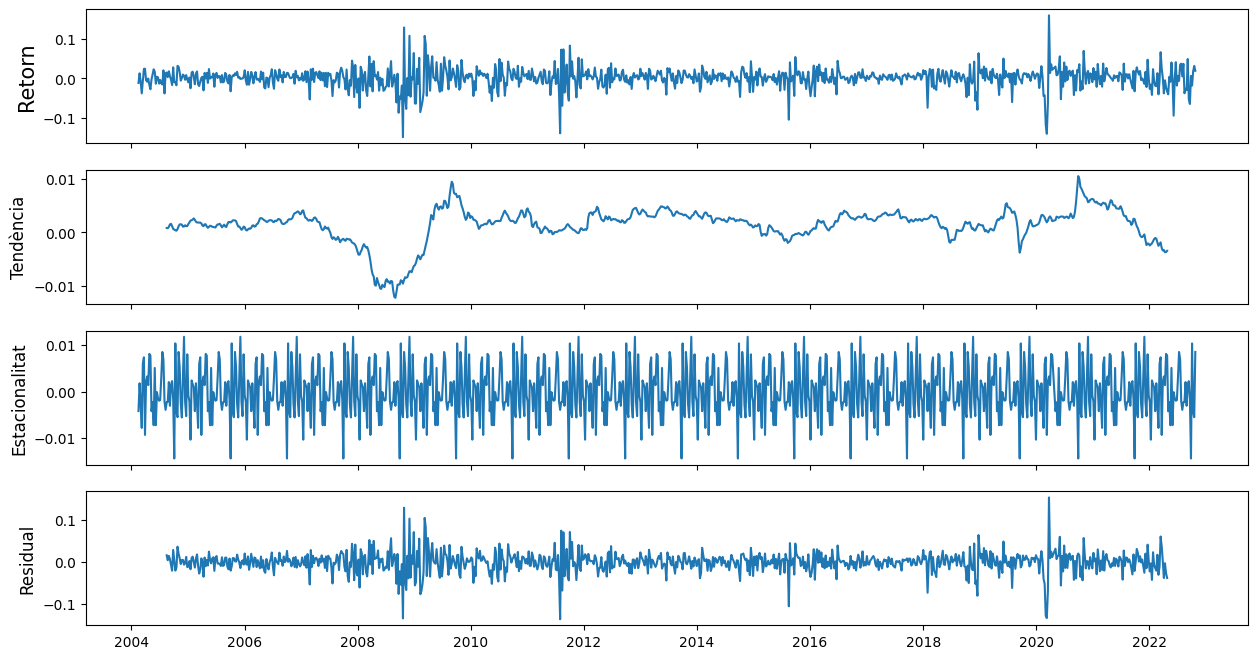

In [37]:
vd.grafic_descomposicio_estacional(pd.DataFrame(dades[dades.columns[0]]),
                                   titol='Retorn', guardar='assets/SP500_return_desc.png')

Notem una tendència, en general, regular i una estacionalitat més dispersa. Tot i això, si ens fixem en les escales de cada component, aquestes dues són menyspreables en comparació a la residual, de tal manera que es pot considerar la sèrie com a estacionària.

A continuació, procedim a analitzar la matriu de correlació entre totes les variables considerades.

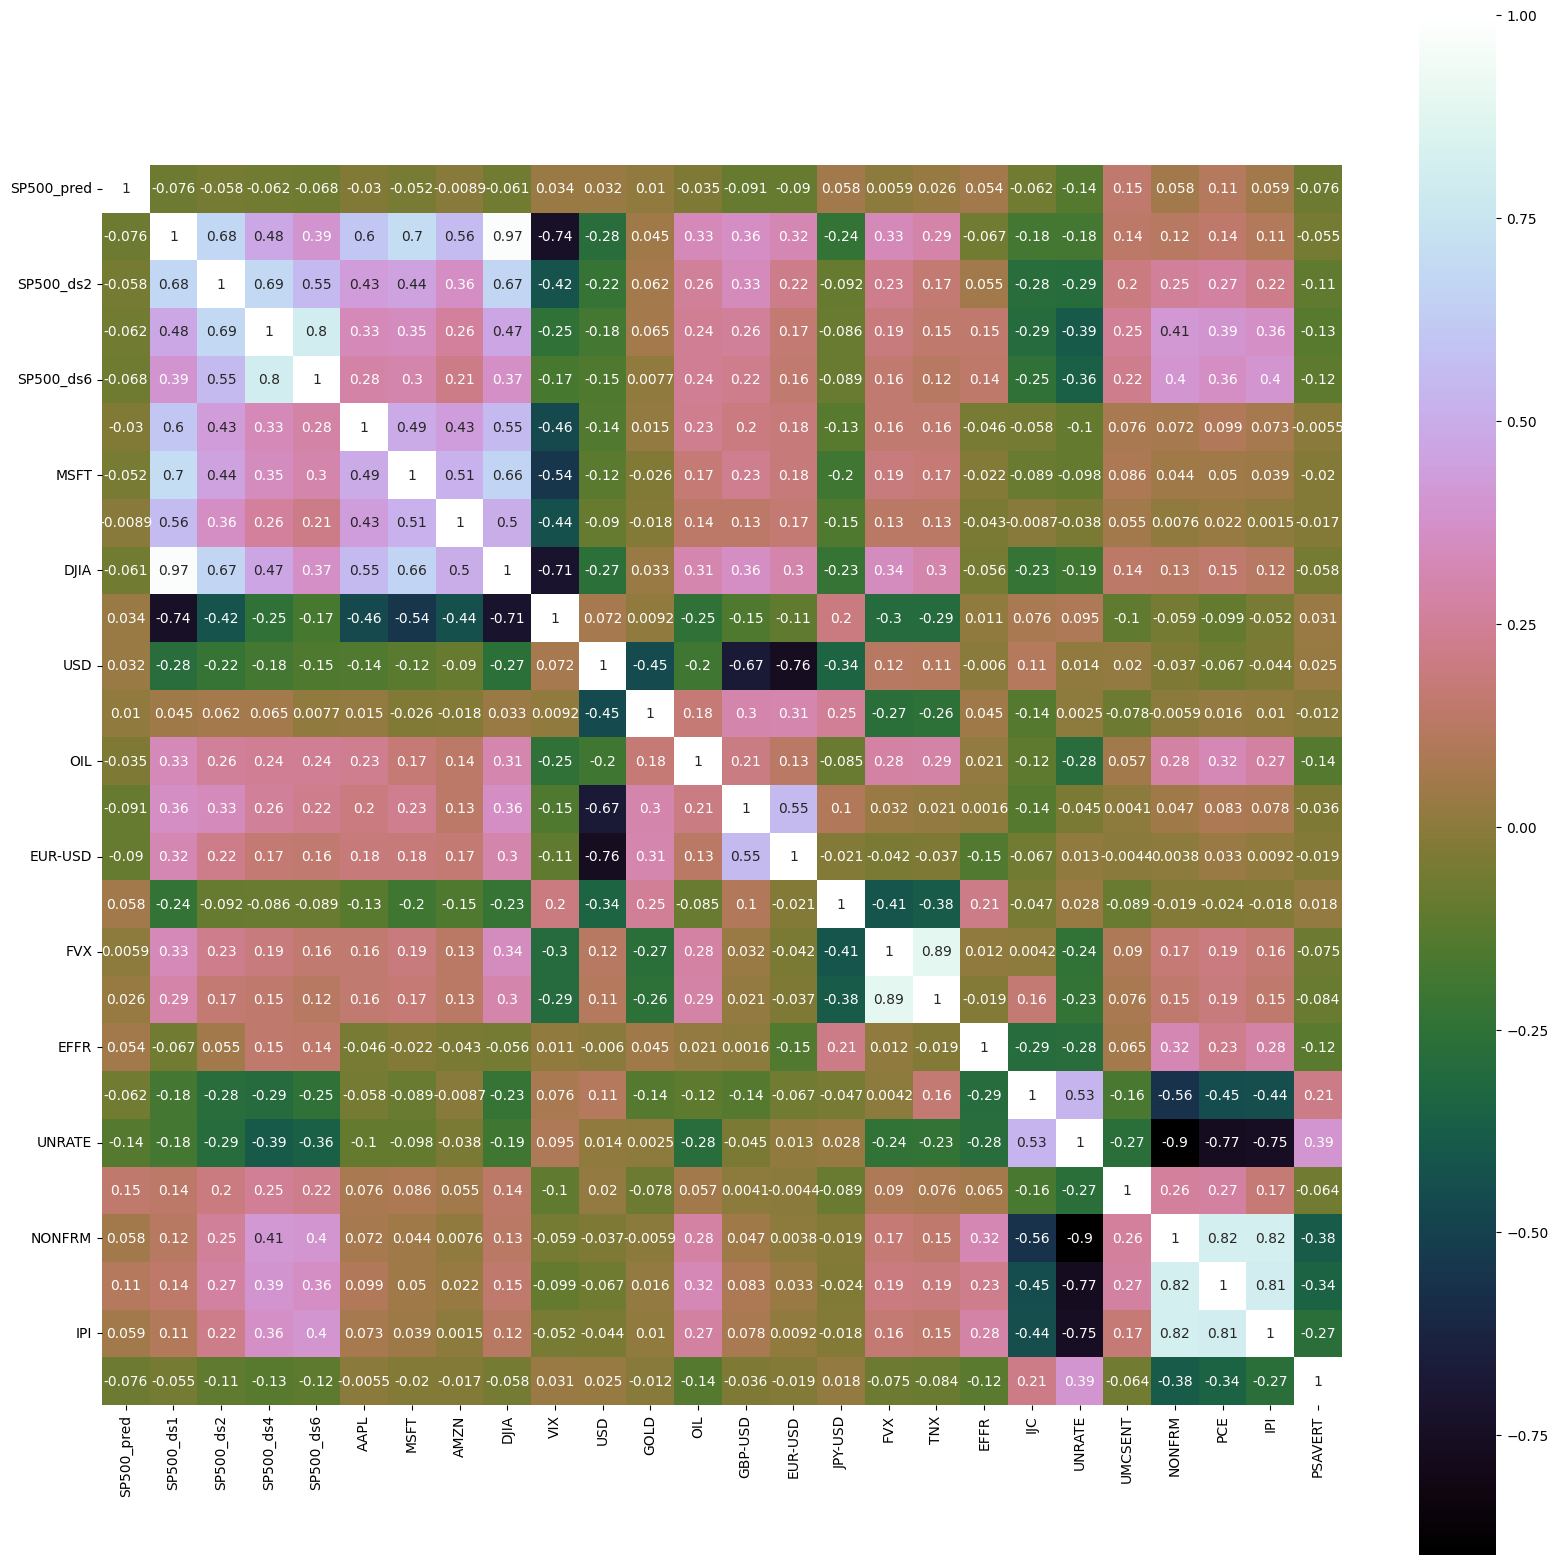

In [38]:
vd.matriu_correlacio(dades)

# la línia següent serveix per a guardar una versió reduïda de la matriu de correlacio
# vd.matriu_correlacio(dades, guardar='assets/correlacio.png', col_guardar=[0, 1, 6, 9, 13, 15, 20, 23], mida_figura=10)

Notem, en diferents graus, certa correlació lineal entre l'etiqueta i algunes d'aquestes característiques. Aquest fet ens pot dur a intuir que l'elecció de variables independents s'ha realitzat adequadament i que aquestes ajudaran en la predicció del rendiment logarítmic de l'índex escollit com a etiqueta, tot i que en cap cas es tracta d'una doble implicació.

Finalment, la matriu de dispersió també és un bon recurs per a detectar relacions existents entre variables.

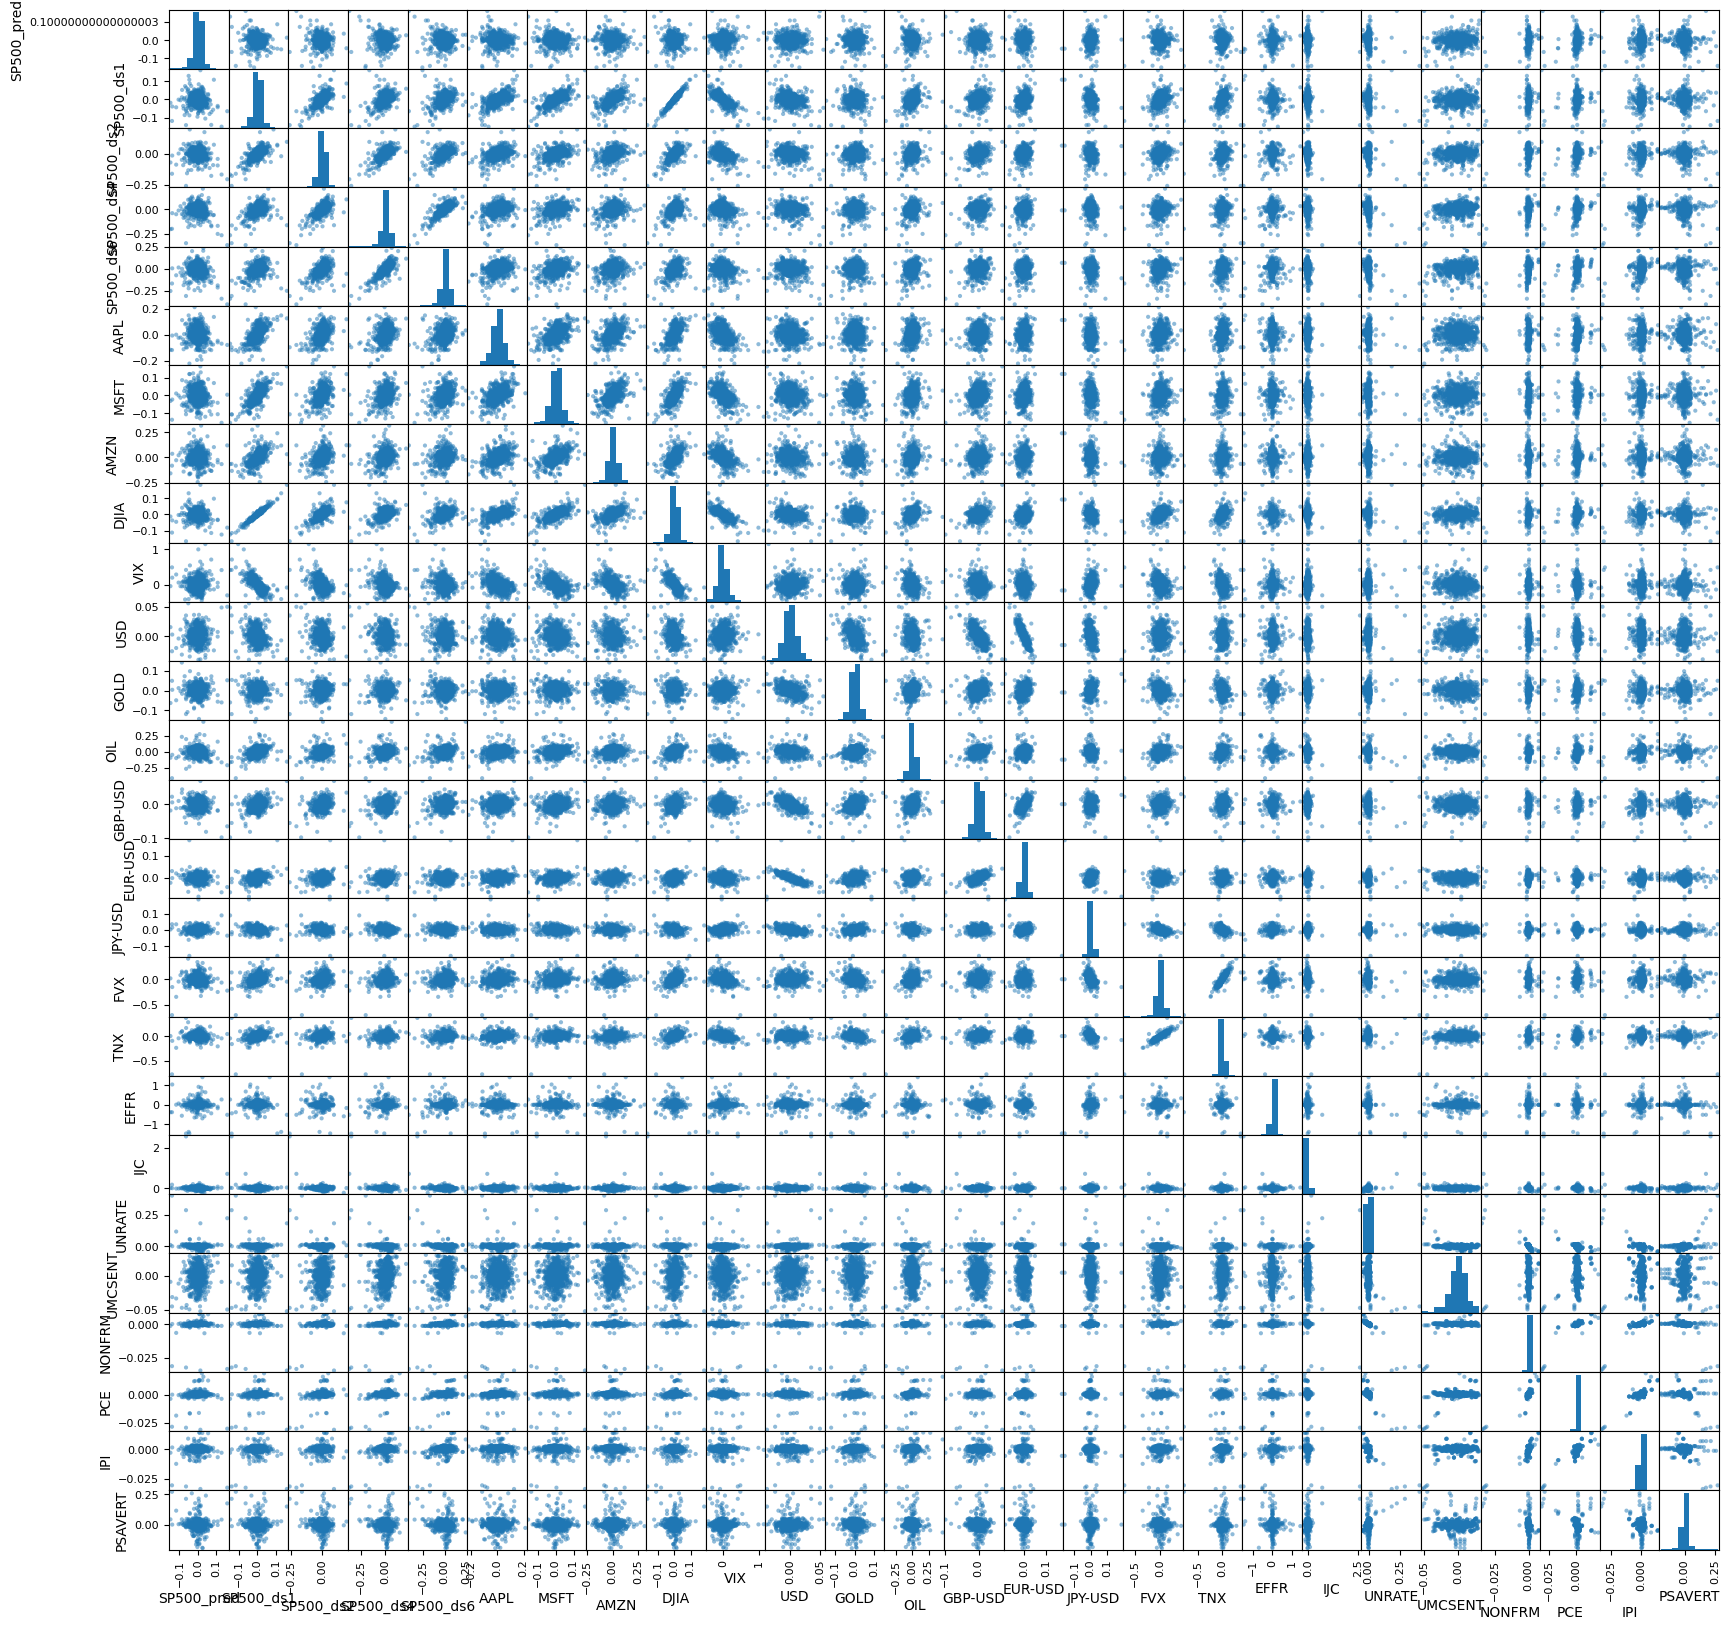

In [39]:
vd.matriu_dispersio(dades)

# la línia següent serveix per a guardar una versió reduïda de la matriu de dispersio
# vd.matriu_dispersio(dades, guardar='assets/scatter.png', col_guardar=[0, 3, 5, 8, 12, 17, 21, 25], mida_figura=10)

Els resultats són diversos: es poden apreciar relacions lineals en alguns casos mentre que en d'altres és difícil identificar el tipus de relació existent.

Després de l'exploració de gràfiques on es veuen representades les variables de l'estudi i relacions existents entre elles, és molt habitual en els problemes d'aprenentatge automàtic usar tècniques de selecció de característiques per a descartar-ne aquelles que es consideri que no tenen influència en el valor final de la variable dependent. Tot i això, aquest recurs resulta d'utilitat quan es disposa d'una llarga llista de variables i usar-ne de poc rellevants pot alentir l'entrenament del model innecessàriament. En aquesta ocasió, degut a que s'estan considerant menys de 25 característiques, s'ha decidit ometre aquest pas i usar-les totes elles per a entrenar el model.

## Disseny i entrenament del model

La secció anterior consistia en la preparació i exploració de les dades del problema. Aquestes s'han emmagatzemat en una única taula indexada temporalment pels dies corresponents a dilluns d'entre l'1 de gener de 2004 i el 31 de desembre de 2022. Abans de ser entrades al model per a ser entrenat, però, cal fer-lis unes petites modificacions més.

Primerament, dividim les variables de la taula completa en 2: una amb una única columna corresponent a la variable que es vol predir, $y$, i una altra amb tota la resta que corresponen a les característiques, $x$. Llavors, fem dues particions pels índexs de cadascuna d'aquestes dues per tal d'agrupar-les en conjunt d'entrenament, de validació i de testeig. Les dades d'entrenament corresponen al primer 64% del conjunt (un 80% d'un 80%), les de validació al següent 16% (un 20% d'un 80%) i les de testeig a l'últim 20%. Així doncs, resulten 6 matrius de dades: *x_ent*, *x_val*, *x_test*, *y_ent*, *y_val* i *y_test*.

In [40]:
from sklearn.model_selection import train_test_split

y = pd.DataFrame(dades[dades.columns[0]])
x = dades.loc[:, dades.columns[1:]]

x_ent, x_test, y_ent, y_test = train_test_split(x.to_numpy(), y.to_numpy(), test_size=0.2, shuffle=False)
x_ent, x_val, y_ent, y_val = train_test_split(x_ent, y_ent, test_size=0.2, shuffle=False)

L'últim pas abans de començar l'entrenament del model d'aprenentatge automàtic consisteix en definir-lo; és a dir, decidir quin model es vol usar i els seus hiper-paràmetres. En aquesta ocasió, s'usarà una xarxa neuronal artificial *LSTM* i per escollir els hiper-paràmetres principals s'utilitzarà la llibreria *optuna*. Tota la lògica referent a la personalització es troba desenvolupada en la llibreria `personalitzacio_model` del paquet `utils` creat pel projecte.

Amb totes les funcions necessàries ja definides, es pot començar la personalització amb un total de 50 intents.

In [41]:
diccionari_dades_personalitzacio = {
    'x': x.to_numpy(),
    'y': y.to_numpy(),
    'x_ent': x_ent,
    'y_ent': y_ent,
    'x_val': x_val,
    'y_val': x_val,
    'x_test': x_test,
    'y_test': y_test
}
personalitzacio = pm.Personalitzacio(dades=diccionari_dades_personalitzacio)

# la següent línia de codi inicia una personalització (en aquest cas està comentada perquè ja s'ha fet prèviament)
# personalitzacio.començar_personalitzacio(n_intents=50)

La personalització ha durat unes hores, i ha donat com a resultat final que el millor intent era el corresponent als hiper-paràmetres `{'n_capes': 2, 'n_neurones': 222, 'memoria': 9, 'vel_apren': 0.0005}` i un error de validació de $MSE = 0.0019775433465838432$.

## Resultats i interpretació

Les dades de testeig són aquelles que s'han separat per a ser utilitzades al final de l'estudi per posar a prova el rendiment del model al moment de fer prediccions sobre mostres noves per ell. Així doncs, es recupera el model que ha resultat amb menor error de validació i s'utilitza per a obtenir la predicció corresponent.

In [42]:
prediccio = personalitzacio.obtenir_prediccio_millor_model()

resultats_test = pd.DataFrame(prediccio['pred_test'], columns=['Predicció'])
resultats_test['Real'] = y[-len(resultats_test):].to_numpy()
resultats_test.index = y.index[-len(resultats_test):]

resultats_total = pd.DataFrame(prediccio['pred_total'], columns=['Predicció'])
resultats_total['Real'] = y[-len(resultats_total):].to_numpy()
resultats_total.index = y.index[-len(resultats_total):]

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-01-06 22:50:14         3117
metadata.json                                  2023-01-06 22:50:14           64
variables.h5                                   2023-01-06 22:50:16      1498280
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
......lstm_1
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...vars
186/186 [==============================] - 0s 2ms/step


El càlcul de l'error quadràtic mig comès en aquesta predicció és un bon recurs per a fer-se una primera idea de la precisió del model.

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(resultats_test['Real'], resultats_test['Predicció'])

0.0010343445203274972

El resultat sembla indicar un bon rendiment del model en les dades de testeig (sobretot si es compara amb l'error de validació de la secció anterior, el qual tenia un valor lleugerament major). Complementem aquesta posada a prova del model mitjançant la representació gràfica dels valor predits del conjunt de testeig en contrast amb els reals.

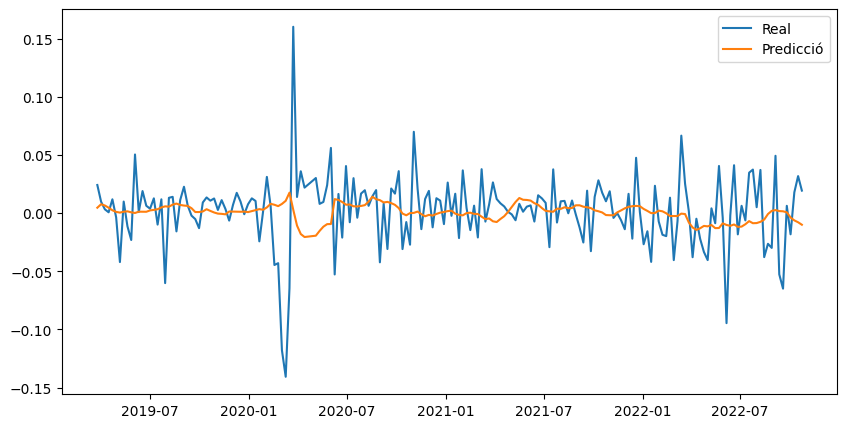

In [44]:
vd.grafic_dades([resultats_test['Real'], resultats_test['Predicció']],
                llegenda=['Real', 'Predicció'],
                guardar='assets/pred_rend_test.png')

Analitzant-la, es pot observar uns valors predits pel model molt suaus en comparació als reals. Sembla que la xarxa neuronal ha tendit a donar resultats amb menys volatilitat i més estables.

La representació del rendiment, però, és més difícil d'interpretar a nivell visual. És per això que també es presenta a continuació la gràfica comparativa amb les sèries temporals del rendiment reals i predits transformats en el preu de l'actiu. El càlcul és immediat aplicant de manera recursiva la transformació inversa a la presentada en l'equació on es defineix al rendiment logarítmic; és a dir: $S_t = S_0 \prod e^{r_i} = S_0 \cdot e^{\sum r_i}$.

In [45]:
primer_tic_test = resultats_test.index[0]
valor_inicial_test = dades_crues[etiqueta].loc[primer_tic_test]
primer_tic_total = resultats_total.index[0]
valor_inicial_total = dades_crues[etiqueta].loc[primer_tic_total]

cum_pred_test =valor_inicial_test*np.exp(resultats_test['Predicció']).cumprod()
cum_real_test = valor_inicial_test*np.exp(resultats_test['Real']).cumprod()
cum_pred = valor_inicial_total*np.exp(resultats_total['Predicció']).cumprod()
cum_real = valor_inicial_total*np.exp(resultats_total['Real']).cumprod()

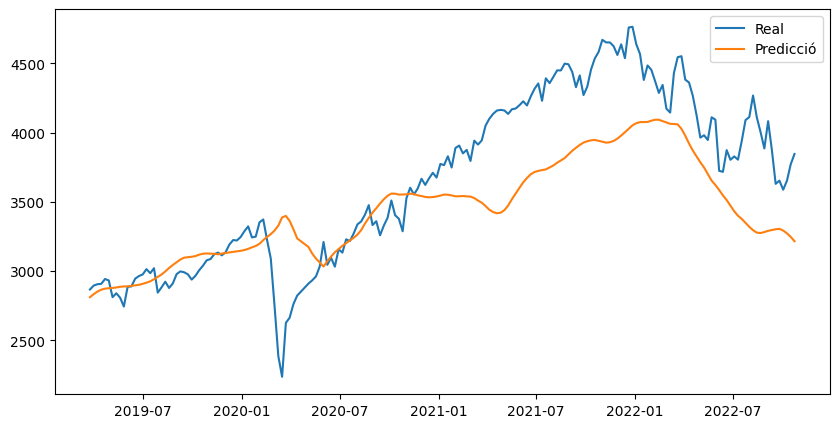

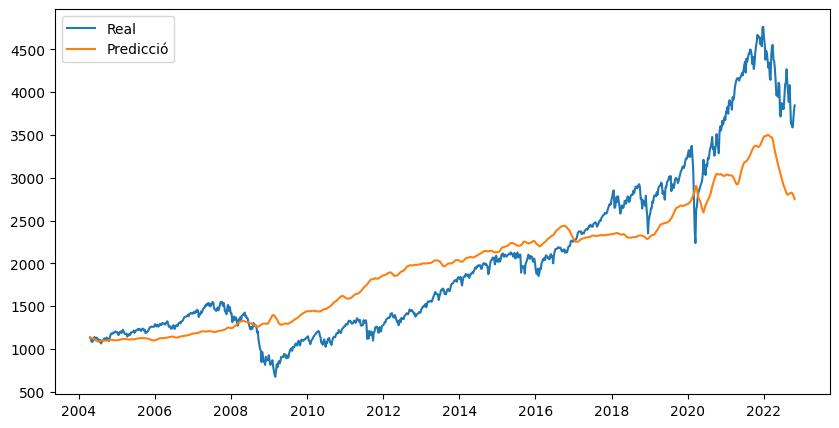

In [46]:
vd.grafic_dades([cum_real_test, cum_pred_test],
                llegenda=['Real', 'Predicció'],
                guardar='assets/pred_preu_test.png')
vd.grafic_dades([cum_real, cum_pred],
                llegenda=['Real', 'Predicció'],
                guardar='assets/pred_preu_total.png')

La visualització de les gràfiques corresponents al preu de l'actiu permeten extreure més conclusions sobre el rendiment del model. Es pot notar que les prediccions capten la tendència general del comportament de l'actiu. Tot i això, s'aprecia un cert desfàs per part del model en la identificació d'un canvi *brusc*, fet que pot resultar un inconvenient si es vol utilitzar aquesta informació per la compra i venda d'actius del mercat borsari.

Recordem, però, que l'objectiu del model era predir el rendiment d'un actiu en el proper tic temporal, de tal manera que al moment de calcular el preu mitjançant el producte acumulat de rendiments, es va acumulant també l'error comès en la predicció. Aquesta propagació d'error es veu reflectida en els tics més llunyans de les gràfiques, en els quals s'aprecia que els valors reals i els predits es troben, en general, més dispersos. Tot i això, comparant les dues representacions en els primers tics de temps, es pot notar un bon rendiment per part del model.

#### Simulacions d'inversió usant les prediccions del model

Per a finalitzar aquest capítol pot ser interessant realitzar alguna simulació de la compra-venda de l'actiu que ha sigut objecte de l'estudi. És a dir, crear una cartera simulada i utilitzar els valors que ha predit el model per a comprar o vendre (seguint un criteri pre-establert) accions de l'índex S&P500. Considerem simulacions que utilitzen només les dades de testeig.

In [47]:
# funció per a generar les simulacions que es presentaran més endavant
def obtenir_simulacio(resultats, inversio_inicial, llindar_curt=0.0, llindar_llarg=0.0):
    simulacio = []
    estic_dins = False
    cartera = inversio_inicial
    for dia_predit in resultats.index:
        prediccio_dia = resultats['Predicció'][dia_predit]
        prediccio_anual = np.exp(52*prediccio_dia) - 1
        real_dia = resultats['Real'][dia_predit]
        if estic_dins:
            if prediccio_anual < llindar_curt:
                estic_dins = False
            else:
                cartera = cartera*np.exp(real_dia)
        if not estic_dins:
            if prediccio_anual >= llindar_llarg:
                estic_dins = True
                cartera = cartera*np.exp(real_dia)
        simulacio.append(cartera)
    simulacio = pd.DataFrame(simulacio)
    simulacio.index = resultats.index
    return  [inversio_inicial*np.exp(resultats['Real']).cumprod(), simulacio]

Comencem plantejant una estratègia d'inversió simple: es disposa d'una inversió inicial (prenem 100 USD, per exemple) i ens col·loquem (o mantenim si ja hi estàvem) en llarg si la predicció del rendiment de la propera setmana és $\geq 0$ o en curt altrament.

In [48]:
inversio_inicial = 100

In [49]:
simulacio_simple = obtenir_simulacio(resultats_test,
                                          inversio_inicial=inversio_inicial)
beneficis_simple = simulacio_simple[1].iloc[-1, 0] - inversio_inicial
beneficis_simple

2.163852707324409

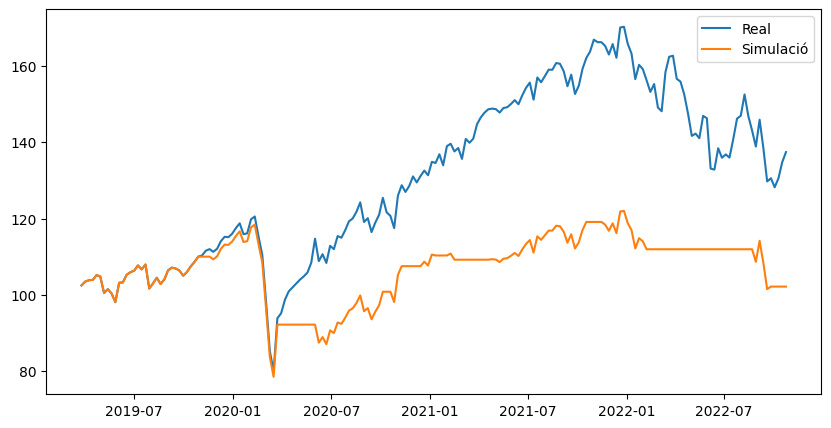

In [50]:
vd.grafic_dades(simulacio_simple,
                llegenda=['Real', 'Simulació'],
                guardar='assets/simulacio_simple.png')

La Figura anterior mostra una comparativa del comportament real de l'actiu i el benefici acumulat de la cartera simulada segons aquesta l'estratègia d'inversió.

Seguint aquest criteri, imitaríem el comportament real de l'actiu a l'inici, fins a arribar a un punt d'altes pèrdues a principis del 2020. Sembla que el model no ha sabut preveure la gran crisi deguda a la Covid-19 (com era d'esperar). Tot i això, a mesura que s'avança en el temps, dóna la impressió que a poc a poc es va *recuperant*. Fent el balanç total d'aquest període, s'obté un benefici global de 2.16 USD per a una inversió inicial de 100 USD. No es tracta d'un guany massa elevat, però tenint en compte la situació, és de valorar que no s'hagi acabat amb pèrdues.

Cal considerar, però, que les transaccions de comprar i vendre una acció tenen un cost addicional. Així doncs, aquest benefici esmentat probablement s'esdevindria en pèrdues en traslladar aquesta simulació al mercat borsari real. Intentem una segona estratègia més elaborada, en la qual, tot i seguir sense afegir els costos reals de transacció (ja que depenen del mercat i estudiar-los no entren dins l'objectiu del treball), es prenguin uns llindars més estrictes per a decidir si comprar o vendre.

Per exemple, prenem la decisió de posar-nos en llarg (si estàvem en curt) si la predicció del rendiment logarítmic setmanal equival a un retorn anual $\geq 10\%$, i de posar-nos en curt (si estàvem en llarg) si equival a un retorn anual $\leq -3\%$. Aquesta conversió és fàcil de fer gràcies a les propietats additives del rendiment logarítmic. En efecte: sigui $r_t$ el rendiment logarítmic setmanal predit, el seu equivalent de retorn anual es calcula mitjançant $R_a = e^{52 \cdot r_t} - 1$, on 52 és el nombre de setmanes que composen 1 any.

La funció `obtenir_simulacio` obté l'evolució de la cartera simulada amb un valor inicial de `inversio_inicial` seguint el criteri indicat amb llindars de compra/venda.

In [51]:
simulacio_llindars = obtenir_simulacio(resultats_test, inversio_inicial=inversio_inicial,
                                       llindar_curt=-0.3, llindar_llarg=0.1)
beneficis_llindars = simulacio_llindars[1].iloc[-1, 0] - inversio_inicial
beneficis_llindars

14.833979027756683

La següent figura mostra la comparativa corresponent a l'estratègia amb llindars comentada. Sembla que el comportament general és similar al cas simple sense llindars, però aconseguint una major recuperació posterior a la caiguda de principis del 2020. D'aquesta manera, acaba resultant un benefici total de 14.83 USD per a la mateixa inversió inicial. Així doncs, mitjançant aquest segon criteri de compra/venda es té més marge de benefici per a afegir-hi els costs de transacció del mercat.

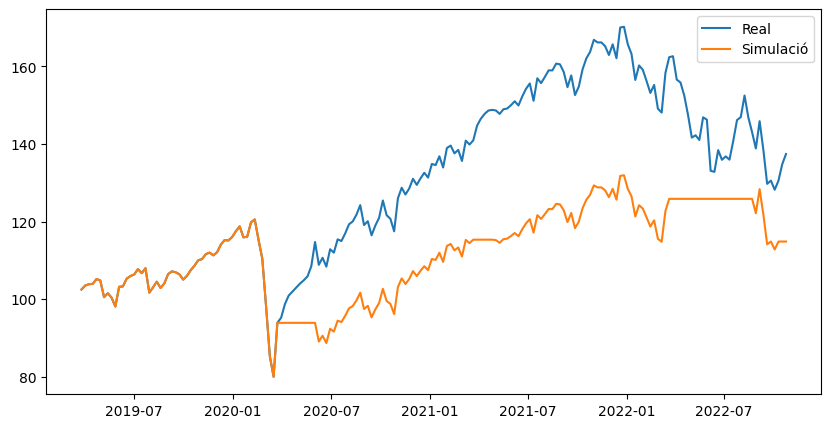

In [52]:
vd.grafic_dades(simulacio_llindars,
                llegenda=['Real', 'Simulació'],
                guardar='assets/simulacio_llindars.png')

En definitiva, es poden donar per satisfactoris els resultats obtinguts de les simulacions usant les prediccions del model. Tot i això, seria recomanable analitzar altres aspectes del comportament de l'actiu (calcular l'*índex de Sharpe* com a mesura de risc o la volatilitat de les dades) per a acabar de formar una estratègia d'inversió més completa. Pels objectius plantejats en aquest estudi, però, s'ha considerat que plantejaments més senzills eren suficients per a fer una valoració global del rendiment del model.